Function

In [1]:

import cobra
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


def load_model():
    model = cobra.io.load_json_model('../data/e_coli_core.json')
    # model.reactions.get_by_id('EX_glc__D_e').bounds
    # model.reactions.get_by_id('EX_o2_e').bounds = (0, 1000)
    # model.reactions.get_by_id('ATPM').bounds = (0, 1000)
    model.reactions.get_by_id('EX_o2_e').lower_bound = -5
    model.objective = 'BIOMASS_Ecoli_core_w_GAM'
    return model


load model and print bounds of Glucose and oxygen and ATPM

In [2]:
model = load_model()

print('Glucose bounds:', model.reactions.get_by_id('EX_glc__D_e').bounds)
print('Oxygen bounds:', model.reactions.get_by_id('EX_o2_e').bounds)
print('ATPM bounds:', model.reactions.get_by_id('ATPM').bounds)


Glucose bounds: (-10.0, 1000.0)
Oxygen bounds: (-5, 1000.0)
ATPM bounds: (8.39, 1000.0)


Optimize Biomass rate
plot r<sub>glucose</sub> -r<sub>biomass</sub> -Y<sub>biomass</sub>

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


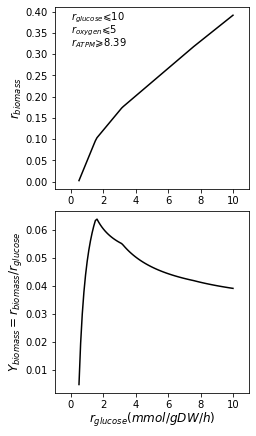

In [3]:

biomass_range = []
glc_range_expect = np.linspace(0, 10, 100)
glc_range = []
yield_range = []
for i in glc_range_expect:
    model.reactions.get_by_id('EX_glc__D_e').bounds = (-i, 0)
    f = model.optimize().fluxes
    biomass_i = f['BIOMASS_Ecoli_core_w_GAM']
    glc_i = f['EX_glc__D_e']

    if model.optimize().status == 'infeasible':  # check ! infeasible, because ATPM lower_bound
        biomass_i = 0
        glc_i = i
        continue
    if glc_i != 0:
        yield_i = abs(biomass_i / glc_i)
    else:
        yield_i = 0
    glc_range.append(i)
    biomass_range.append(biomass_i)
    yield_range.append(abs(biomass_i / glc_i))

fontsize = 12
fig, axs = plt.subplots(2, 1, figsize=(3.5, 6))
ax1 = axs[0]
ax1.plot(glc_range, biomass_range, color='black')
ax1.set_ylabel("$r_{biomass}$", fontsize=fontsize, labelpad=1)
ax1.set(xlim=(-1, 11), xticks=np.arange(0, 12, 2), )
ax1.text(0, 0.38, r'$r_{glucose} \leqslant 10 $', fontsize=10)
ax1.text(0, 0.35, r'$r_{oxygen} \leqslant 5 $', fontsize=10)
ax1.text(0, 0.32, r'$r_{ATPM} \geqslant 8.39 $', fontsize=10)

ax2 = axs[1]
ax2.plot(glc_range, yield_range, color='black')
ax2.set(xlim=(-1, 11), xticks=np.arange(0, 12, 2), )
ax2.set_xlabel("$r_{glucose} (mmol/gDW/h)$", fontsize=fontsize, labelpad=1)
ax2.set_ylabel("$Y_{biomass} = r_{biomass}/ r_{glucose}$", fontsize=fontsize, labelpad=1)

plt.tight_layout(pad=0.5, w_pad=2, h_pad=0.5)
plt.show()


Optimize Acetate rate
plot r<sub>glucose</sub> -r<sub>acetate</sub> -Y<sub>acetate</sub>

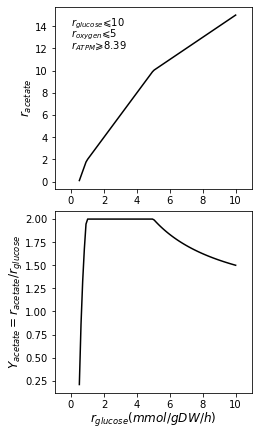

In [4]:
model = load_model()
model.objective = 'EX_ac_e'

acetate_range = []
glc_range_expect = np.linspace(0, 10, 100)
glc_range = []
yield_range = []
for i in glc_range_expect:
    model.reactions.get_by_id('EX_glc__D_e').bounds = (-i, 0)
    f = model.optimize().fluxes
    acetate_i = f['EX_ac_e']
    glc_i = f['EX_glc__D_e']

    if model.optimize().status == 'infeasible':
        acetate_i = 0
        glc_i = i
        continue

    if glc_i != 0:
        yield_i = abs(acetate_i / glc_i)
    else:
        yield_i = 0

    glc_range.append(abs(glc_i))
    acetate_range.append(acetate_i)
    yield_range.append(abs(acetate_i / glc_i))

fontsize = 12
fig, axs = plt.subplots(2, 1, figsize=(3.5, 6))
ax1 = axs[0]
ax1.plot(glc_range, acetate_range, color='black')
ax1.set_ylabel("$r_{acetate}$", fontsize=fontsize, labelpad=1)
ax1.set(xlim=(-1, 11), xticks=np.arange(0, 12, 2), )
ax1.text(0, 14, r'$r_{glucose} \leqslant 10 $', fontsize=10)
ax1.text(0, 13, r'$r_{oxygen} \leqslant 5 $', fontsize=10)
ax1.text(0, 12, r'$r_{ATPM} \geqslant 8.39 $', fontsize=10)

ax2 = axs[1]
ax2.plot(glc_range, yield_range, color='black')
ax2.set_xlabel("$r_{glucose} (mmol/gDW/h)$", fontsize=fontsize, labelpad=1)
ax2.set_ylabel("$Y_{acetate} = r_{acetate}/ r_{glucose}$", fontsize=fontsize, labelpad=1)
ax2.set(xlim=(-1, 11), xticks=np.arange(0, 12, 2), )

plt.tight_layout(pad=0.5, w_pad=2, h_pad=0.5)
plt.show()


Production envelopes

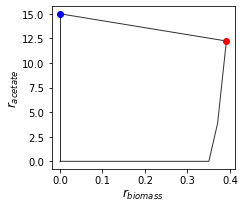

In [5]:
model = load_model()


def plot_opt_envelope(model_, rxn_x, rxn_y):
    model = model_.copy()

    model.objective = rxn_x
    f_max = model.optimize().objective_value

    model.objective_direction = 'min'
    f_min = model.optimize().objective_value

    x_range = np.linspace(f_min, f_max, num=20)

    model.objective_direction = 'max'

    y_max_range = []
    y_min_range = []
    for x in x_range:
        model.reactions.get_by_id(rxn_x).bounds = (x, x)
        model.objective = rxn_y
        model.objective_direction = 'max'
        y_max = model.optimize().objective_value
        if model.optimize().status != 'optimal':
            print(x)
            continue

        model.objective_direction = 'min'
        y_min = model.optimize().objective_value
        if model.optimize().status != 'optimal':
            continue

        y_max_range.append(y_max)
        y_min_range.append(y_min)

    fontsize = 12
    fig, axs = plt.subplots(1, 1, figsize=(3.5, 3))
    ax1 = axs
    ax1.plot(x_range, y_max_range, color='black', alpha=0.8, lw=1)
    ax1.plot(x_range, y_min_range, color='black', alpha=0.8, lw=1)

    ax1.plot([x_range[0], x_range[0]], [y_max_range[0], y_min_range[0]], color='black', alpha=0.8, lw=1)
    ax1.plot([x_range[0]], [y_max_range[0]], 'o', color='blue', alpha=1, label='Max acetate rate')
    ax1.plot([x_range[-1]], [y_max_range[-1]], 'o', color='red', alpha=1, label='Max biomass rate')
    # ax1.legend(fontsize=8)

    ax1.set_xlabel("$r_{biomass}$", fontsize=fontsize, labelpad=1)
    ax1.set_ylabel("$r_{acetate}$", fontsize=fontsize, labelpad=1)
    plt.tight_layout()

    plt.show()


plot_opt_envelope(model, 'BIOMASS_Ecoli_core_w_GAM', 'EX_ac_e')


Yield space from EFVs

/var/folders/f_/qxjgggy53kgf53y_ytc_6nt1s_zp5x/T/ipykernel_66277/3980003831.py:40 UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


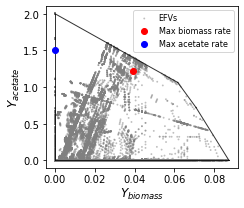

In [6]:

core_EFVs_z = np.genfromtxt('../data/e_coli_core_EFVs_standardized.csv', delimiter=',')
EFVs_all_points = core_EFVs_z.T  # columns : glc, biomass ac,
xy_EFVs = EFVs_all_points[:, [1, 2]]  # indexes for biomass and ac

model = load_model()

# max biomass rate and max ac rate fluxes (red and blue)
f_biomass = model.optimize().fluxes

model.objective = 'EX_ac_e'
f_ac = model.optimize().fluxes

# plot
figsize = (3.5, 3)
fontsize = 12
fig, ax = plt.subplots(figsize=figsize)

points_EFVs = ax.scatter(xy_EFVs[:, 0], xy_EFVs[:, 1], s=3, marker='.', color='none',
                         alpha=0.5, edgecolors='grey', label='EFVs')

qhull_options = 'QJ Qx A0.9999999'
hull_EFVs = ConvexHull(xy_EFVs, qhull_options=qhull_options)
for simplex in hull_EFVs.simplices:
    line_EFVs = ax.plot(xy_EFVs[simplex, 0], xy_EFVs[simplex, 1], '-', markerfacecolor='none',
                        color='black', alpha=0.8, markersize=5, lw=1)

ax.plot(-f_biomass['BIOMASS_Ecoli_core_w_GAM'] / f_biomass['EX_glc__D_e'],
        -f_biomass['EX_ac_e'] / f_biomass['EX_glc__D_e'], 'o',
        color='red', alpha=1, label='Max biomass rate')
ax.plot(-f_ac['BIOMASS_Ecoli_core_w_GAM'] / f_biomass['EX_glc__D_e'],
        -f_ac['EX_ac_e'] / f_biomass['EX_glc__D_e'], 'o',
        color='blue', alpha=1, label='Max acetate rate')

# ax.set_ylabel('Yield: Acetate/Glucose', )
# ax.set_xlabel('Yield: Biomass/Glucose', )
ax.set_xlabel("$Y_{biomass}$", fontsize=fontsize, labelpad=1)
ax.set_ylabel("$Y_{acetate}$", fontsize=fontsize, labelpad=1)
ax.legend(fontsize=8)
fig.tight_layout()
fig.show()